Let's look at different metrics and hyper parameters for model optimization.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, confusion_matrix,make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

 **make scorer**  - usually refers to creating a custom scoring function that can be used with scikit-learn's model evaluation tools, like cross_val_score, GridSearchCV, or RandomizedSearchCV.

In [4]:
x,y = load_breast_cancer(return_X_y = True, as_frame = True)

In [13]:
y = y.map({0:1, 1:0})

In [14]:
x.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [15]:
x.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [16]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [18]:
y.value_counts()/len(y)

target
0    0.627417
1    0.372583
Name: count, dtype: float64

here it shows the target value distributions.

let's find FNR (false negative rate) seperately as It's a crucial metric in evaluating classification models, especially when the cost of missing a "positive" case is high.

In [52]:
def fnr(y_true,y_pred):
    tn,tp,fn,fp = confusion_matrix(y_true,y_pred,labels = [0,1]).ravel() # converts the result to 1d array
    FNR = fn/(tp+fn)
    return FNR

In [53]:
fnr_score = make_scorer(fnr, greater_is_better = False,response_method = 'predict')# lower FNR values are better

**make_scorer(...)**: This function from sklearn.metrics converts your custom fnr function into a "scorer" object that GridSearchCV (and other scikit-learn tools) can use.

**response_method = 'predict'**: This tells make_scorer how the model should generate its predictions for the scoring function. For classification metrics like FNR (which needs discrete class labels), the model's predict() method (which returns 0s or 1s) is appropriate.

In [54]:
rf_model = RandomForestClassifier(n_estimators=100,max_depth = 1, random_state=0,n_jobs =4) #n_jobs = use 4 cpu core.

In [55]:
rf_param_grid = dict(n_estimators=[10,20,50,100,200,500,1000,2000],max_depth = [1,2,3,4])

This creates a dictionary specifying the ranges of hyperparameters that GridSearchCV will test for your 'rf_model'. GridSearchCV will test every possible combination of these values (8 * 4 = 32 combinations).

In [56]:
clf = GridSearchCV(rf_model, rf_param_grid, scoring=fnr_score, cv=5) #tests all hyperparamter and finds one with lowest fnr

**clf = GridSearchCV(...)**: This initializes the GridSearchCV object.

**rf_model**: The machine learning model you want to tune.

**rf_param_grid**: The dictionary defining the hyperparameters and their values to test.

**scoring=fnr_score**: This is the crucial part. It tells GridSearchCV to use your custom fnr_score (which aims to minimize FNR) as the metric to evaluate model performance during the search.

**cv=5**: This specifies that 5-fold cross-validation should be used. For each combination of hyperparameters, the training data (x, y) will be split into 5 folds, and the model will be trained on 4 folds and tested on the remaining 1 fold, repeating this 5 times. The FNR score for each combination will be the average across these 5 runs.

In [57]:
search = clf.fit(x,y)

This command starts the actual grid search process. It iterates through all combinations in rf_param_grid, trains and evaluates an rf_model for each using 5-fold cross-validation, and keeps track of which combination yields the best (lowest, in this case) FNR score.

In [58]:
search.best_params_

{'max_depth': 3, 'n_estimators': 1000}

After clf.fit(x,y) completes, search.best_params_ will be a dictionary containing the specific n_estimators and max_depth values that resulted in the lowest False Negative Rate during the cross-validation process.

In [59]:
# Select multiple columns by passing a list of column names
results = pd.DataFrame(search.cv_results_)[['params','mean_test_score','std_test_score']]

**search.cv_results_**: After you run **clf.fit(x,y)** (which you stored in **search**), the search object (your fitted GridSearchCV instance) contains an attribute called **cv_results_**. This is a dictionary that holds detailed results for every single hyperparameter combination that GridSearchCV evaluated during its cross-validation process. It includes information like training scores, test scores, fit times, score times, and the parameters used for each run.

In [60]:
results.sort_values(by = 'mean_test_score', ascending = False, inplace = True)

In [61]:
results.reset_index(drop = True, inplace = True)

After sorting, the DataFrame's index will be scattered (e.g., if row 5 became the new row 0, its index would still be 5).

**reset_index()**: This method resets the DataFrame's index to a default integer index (0, 1, 2, ...).

**drop = True**: This is important! It prevents the old, jumbled index from being added as a new column in your DataFrame.

array([<Axes: >], dtype=object)

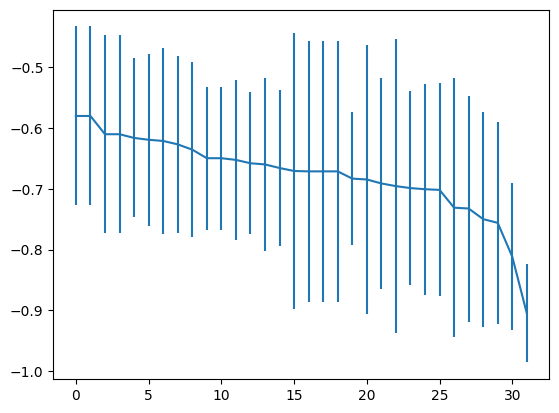

In [62]:
results['mean_test_score'].plot(yerr = [results['std_test_score'],results['std_test_score']],subplots =True)

**results['mean_test_score'].plot(...)**: This line generates a plot using the mean_test_score column. By default, it will plot the scores against their new sequential index (0, 1, 2,...), representing each tested hyperparameter combination.

**yerr = [results['std_test_score'], results['std_test_score']]**: This adds error bars to your plot. The error bars will extend one standard deviation (std_test_score) above and one standard deviation below each mean_test_score point.

It visually represents the variability or consistency of the model's performance across the 5 cross-validation folds for each hyperparameter set. A smaller error bar means the model was more consistent; a larger one means its performance varied more across different data splits.